# Implement a tiny version of YOLO with DIOR dataset

## Import libraries

In [37]:
import os
import shutil
import gdown
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from xml.etree import ElementTree
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torchinfo import summary


## Import Data

In [2]:
raw_data_path = "raw_data"

In [3]:
if os.path.exists(raw_data_path):
    print('[INFO] Raw data directory exists, skiping download.')
else:
    os.makedirs(raw_data_path)
    print('[INFO] Raw data directory is been created.')
    print('[INFO] Downloading data...\n')
    gdown.download('https://drive.google.com/uc?id=1KoQzqR20qvIXDf1qsXCHGxD003IPmXMw', output=os.path.join(raw_data_path, 'Annotations.zip'))
    gdown.download('https://drive.google.com/file/d/1wq0FQCBsbrnf-sJfloi7IR9tBH87GGGS/view?usp=sharing', output=os.path.join(raw_data_path, 'JPEGImages-test.zip'),fuzzy=True)
    gdown.download('https://drive.google.com/file/d/1NVRSBm3RfpGGtZvgLJG5e_XD9uP4DZmI/view?usp=sharing', output=os.path.join(raw_data_path, 'JPEGImages-trainval.zip'),fuzzy=True)
    print('[INFO] Data is been downloaded.')

[INFO] Raw data directory exists, skiping download.


In [4]:
dior_data_path = "dior_data"

In [5]:
# Extracting the zip data files
if os.path.exists(dior_data_path):
    print('[INFO] DIOR data directory exists, skiping extraction.')
else:
    os.makedirs(dior_data_path)
    for i in os.listdir(raw_data_path):
        filename = os.path.join(raw_data_path, i) 
        shutil.unpack_archive(filename=filename, extract_dir=dior_data_path)
        print(f'[INFO] File "{filename}" is been extracted to "{dior_data_path}".')

[INFO] DIOR data directory exists, skiping extraction.


In [6]:
# Path for all the data
annot_data_path = 'dior_data/Annotations/Horizontal Bounding Boxes'
trainval_data_path = 'dior_data/JPEGImages-trainval'
test_data_path = 'dior_data/JPEGImages-test'

In [7]:
# Creating a list of annotation files
annot_file_list = sorted([os.path.join(annot_data_path, i) for i in os.listdir(annot_data_path) if '.xml' in i])
annot_file_list[:5], annot_file_list[-5:], len(annot_file_list)

(['dior_data/Annotations/Horizontal Bounding Boxes/00001.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/00002.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/00003.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/00004.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/00005.xml'],
 ['dior_data/Annotations/Horizontal Bounding Boxes/23459.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/23460.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/23461.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/23462.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/23463.xml'],
 23463)

In [8]:
# Creating a list of training and validation images
trainval_file_list = sorted([os.path.join(trainval_data_path, i) for i in os.listdir(trainval_data_path) if '.jpg' in i])
trainval_file_list[:5], trainval_file_list[-5:], len(trainval_file_list)

(['dior_data/JPEGImages-trainval/00001.jpg',
  'dior_data/JPEGImages-trainval/00002.jpg',
  'dior_data/JPEGImages-trainval/00003.jpg',
  'dior_data/JPEGImages-trainval/00004.jpg',
  'dior_data/JPEGImages-trainval/00005.jpg'],
 ['dior_data/JPEGImages-trainval/11721.jpg',
  'dior_data/JPEGImages-trainval/11722.jpg',
  'dior_data/JPEGImages-trainval/11723.jpg',
  'dior_data/JPEGImages-trainval/11724.jpg',
  'dior_data/JPEGImages-trainval/11725.jpg'],
 11725)

In [9]:
# Creating a list of testing images
test_file_list = sorted([os.path.join(test_data_path, i) for i in os.listdir(test_data_path) if '.jpg' in i])
test_file_list[:5], test_file_list[-5:], len(test_file_list)

(['dior_data/JPEGImages-test/11726.jpg',
  'dior_data/JPEGImages-test/11727.jpg',
  'dior_data/JPEGImages-test/11728.jpg',
  'dior_data/JPEGImages-test/11729.jpg',
  'dior_data/JPEGImages-test/11730.jpg'],
 ['dior_data/JPEGImages-test/23459.jpg',
  'dior_data/JPEGImages-test/23460.jpg',
  'dior_data/JPEGImages-test/23461.jpg',
  'dior_data/JPEGImages-test/23462.jpg',
  'dior_data/JPEGImages-test/23463.jpg'],
 11738)

In [10]:
# Combining all the images path in one list
image_data_file_list = np.concatenate((trainval_file_list, test_file_list))
image_data_file_list[:5], image_data_file_list[-5:], len(image_data_file_list)

(array(['dior_data/JPEGImages-trainval/00001.jpg',
        'dior_data/JPEGImages-trainval/00002.jpg',
        'dior_data/JPEGImages-trainval/00003.jpg',
        'dior_data/JPEGImages-trainval/00004.jpg',
        'dior_data/JPEGImages-trainval/00005.jpg'], dtype='<U39'),
 array(['dior_data/JPEGImages-test/23459.jpg',
        'dior_data/JPEGImages-test/23460.jpg',
        'dior_data/JPEGImages-test/23461.jpg',
        'dior_data/JPEGImages-test/23462.jpg',
        'dior_data/JPEGImages-test/23463.jpg'], dtype='<U39'),
 23463)

## Data analysis

In [11]:
# Extracting data from annotation files
meta_list = [] # To store general info for every image
object_list_train = [] # To store object classes info of train dataset
object_list_test = [] # To store object classes info of test dataset

for file in tqdm(annot_file_list):
    meta_dict = {}
    root = ElementTree.parse(file).getroot()
    
    # Filename - extracted
    for path in image_data_file_list:
        if root.find('filename').text in path:
            meta_dict['filename'] = path
            meta_dict['split_type'] = path.split('/')[1]
    
    # Width - extracted
    meta_dict['width'] = int(root.find('size').find('width').text)
    
    # Height - extracted
    meta_dict['height'] = int(root.find('size').find('height').text)
    
    # Objects - extracted and combined into a single string
    meta_dict['objects'] = ', '.join(np.unique([obj.find('name').text for obj in root.findall('object')]))
    meta_list.append(meta_dict)
    
    # Collecting all the object classes instance and counting total appearance
    for obj in root.findall('object'):
        if meta_dict['split_type'] == 'JPEGImages-trainval':
            object_list_train.append(obj.find('name').text)
        elif meta_dict['split_type'] == 'JPEGImages-test':
            object_list_test.append(obj.find('name').text)
    
# Counting the instance for every object class
object_instance_list_train = Counter(sorted(object_list_train))
object_instance_list_test = Counter(sorted(object_list_test))
    
# Collecting Class list and indexing it also in a sequence
class_dict = {k: v for v, k in enumerate(sorted(np.unique(object_list_train)))}

meta_list[:5], object_instance_list_train, object_instance_list_test, class_dict

100%|██████████| 23463/23463 [03:31<00:00, 110.69it/s]


([{'filename': 'dior_data/JPEGImages-trainval/00001.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'golffield'},
  {'filename': 'dior_data/JPEGImages-trainval/00002.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'Expressway-toll-station, vehicle'},
  {'filename': 'dior_data/JPEGImages-trainval/00003.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'trainstation'},
  {'filename': 'dior_data/JPEGImages-trainval/00004.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'chimney'},
  {'filename': 'dior_data/JPEGImages-trainval/00005.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'storagetank, vehicle'}],
 Counter({'ship': 27351,
          'vehicle': 13725,
          'tenniscourt': 4898,
          'storagetank': 3042,
          'baseballfield': 2384,
          '

In [12]:
# Creating a dataframe from the extracted data
meta_df = pd.DataFrame(meta_list)
meta_df

,filename,split_type,width,height,objects
0,dior_data/JPEGImages-trainval/00001.jpg,JPEGImages-trainval,800,800,golffield
1,dior_data/JPEGImages-trainval/00002.jpg,JPEGImages-trainval,800,800,"Expressway-toll-station, vehicle"
2,dior_data/JPEGImages-trainval/00003.jpg,JPEGImages-trainval,800,800,trainstation
3,dior_data/JPEGImages-trainval/00004.jpg,JPEGImages-trainval,800,800,chimney
4,dior_data/JPEGImages-trainval/00005.jpg,JPEGImages-trainval,800,800,"storagetank, vehicle"
...,...,...,...,...,...
23458,dior_data/JPEGImages-test/23459.jpg,JPEGImages-test,800,800,vehicle
23459,dior_data/JPEGImages-test/23460.jpg,JPEGImages-test,800,800,"groundtrackfield, tenniscourt, vehicle"
23460,dior_data/JPEGImages-test/23461.jpg,JPEGImages-test,800,800,"overpass, vehicle"
23461,dior_data/JPEGImages-test/23462.jpg,JPEGImages-test,800,800,"overpass, vehicle"


In [13]:
print(f'Size of the images width: {meta_df.width.unique()[0]} and height: {meta_df.height.unique()[0]}')
print(f'Total number of classes with all possible combination: {len(meta_df.objects.unique())}')
print(f'Total length of the training/validation dataset: {len(meta_df[meta_df["split_type"] == "JPEGImages-trainval"])} and testing dataset: {len(meta_df[meta_df["split_type"] == "JPEGImages-test"])}')

Size of the images width: 800 and height: 800
Total number of classes with all possible combination: 526
Total length of the training/validation dataset: 11725 and testing dataset: 11738


Text(0.5, 1.0, 'Top 20 Objects Classes')

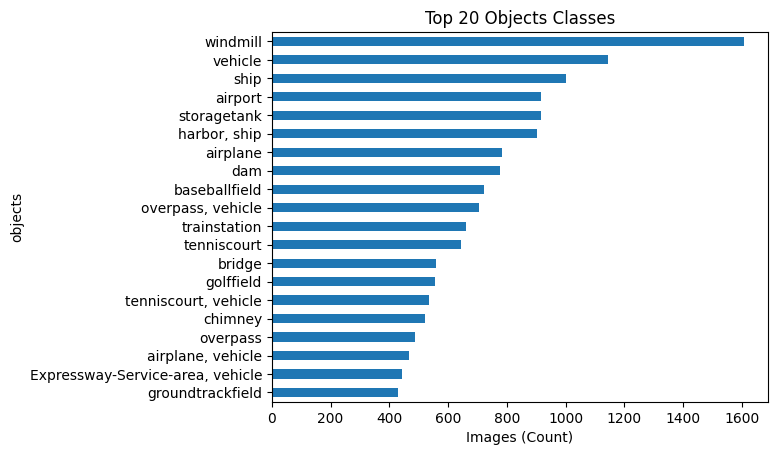

In [14]:
# Top 20 classes in the dataset
meta_df.objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Top 20 Objects Classes')

Text(0.5, 0.98, 'Top 20 Objects Classes in the Dataset')

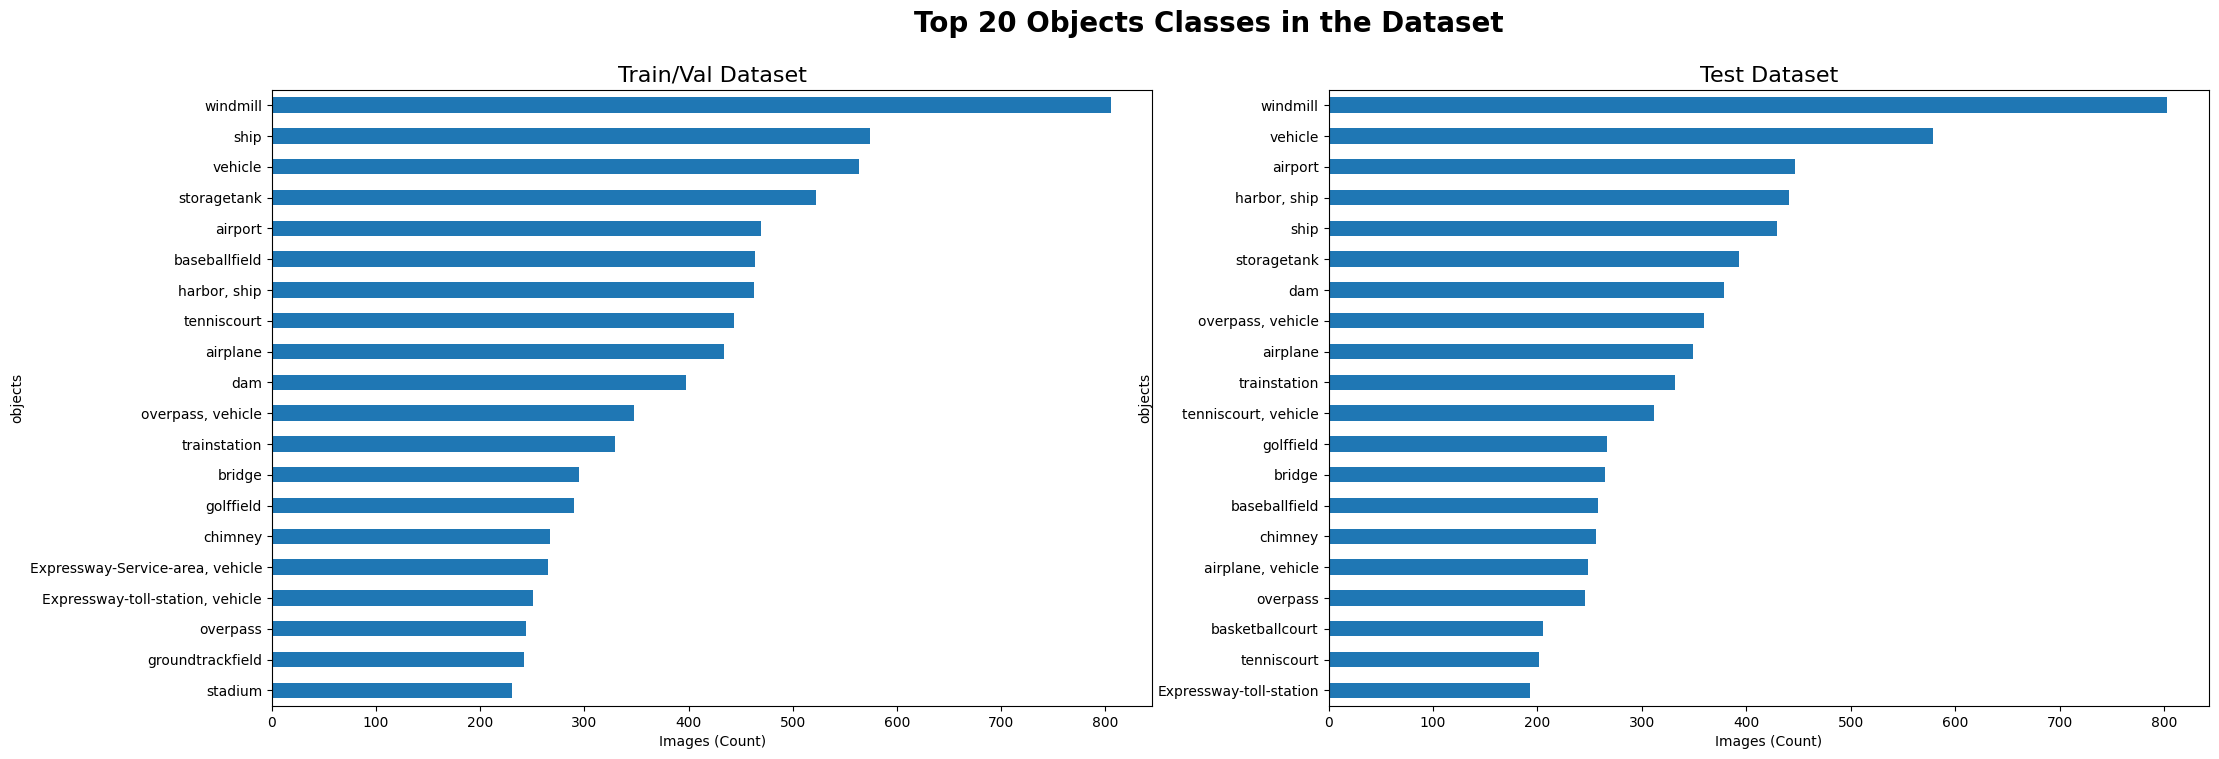

In [15]:
plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
meta_df[meta_df["split_type"] == "JPEGImages-trainval"].objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Train/Val Dataset', fontsize=16)
plt.subplot(1, 2, 2)
meta_df[meta_df["split_type"] == "JPEGImages-test"].objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Test Dataset', fontsize=16)
plt.suptitle('Top 20 Objects Classes in the Dataset', fontsize=20, fontweight='bold')

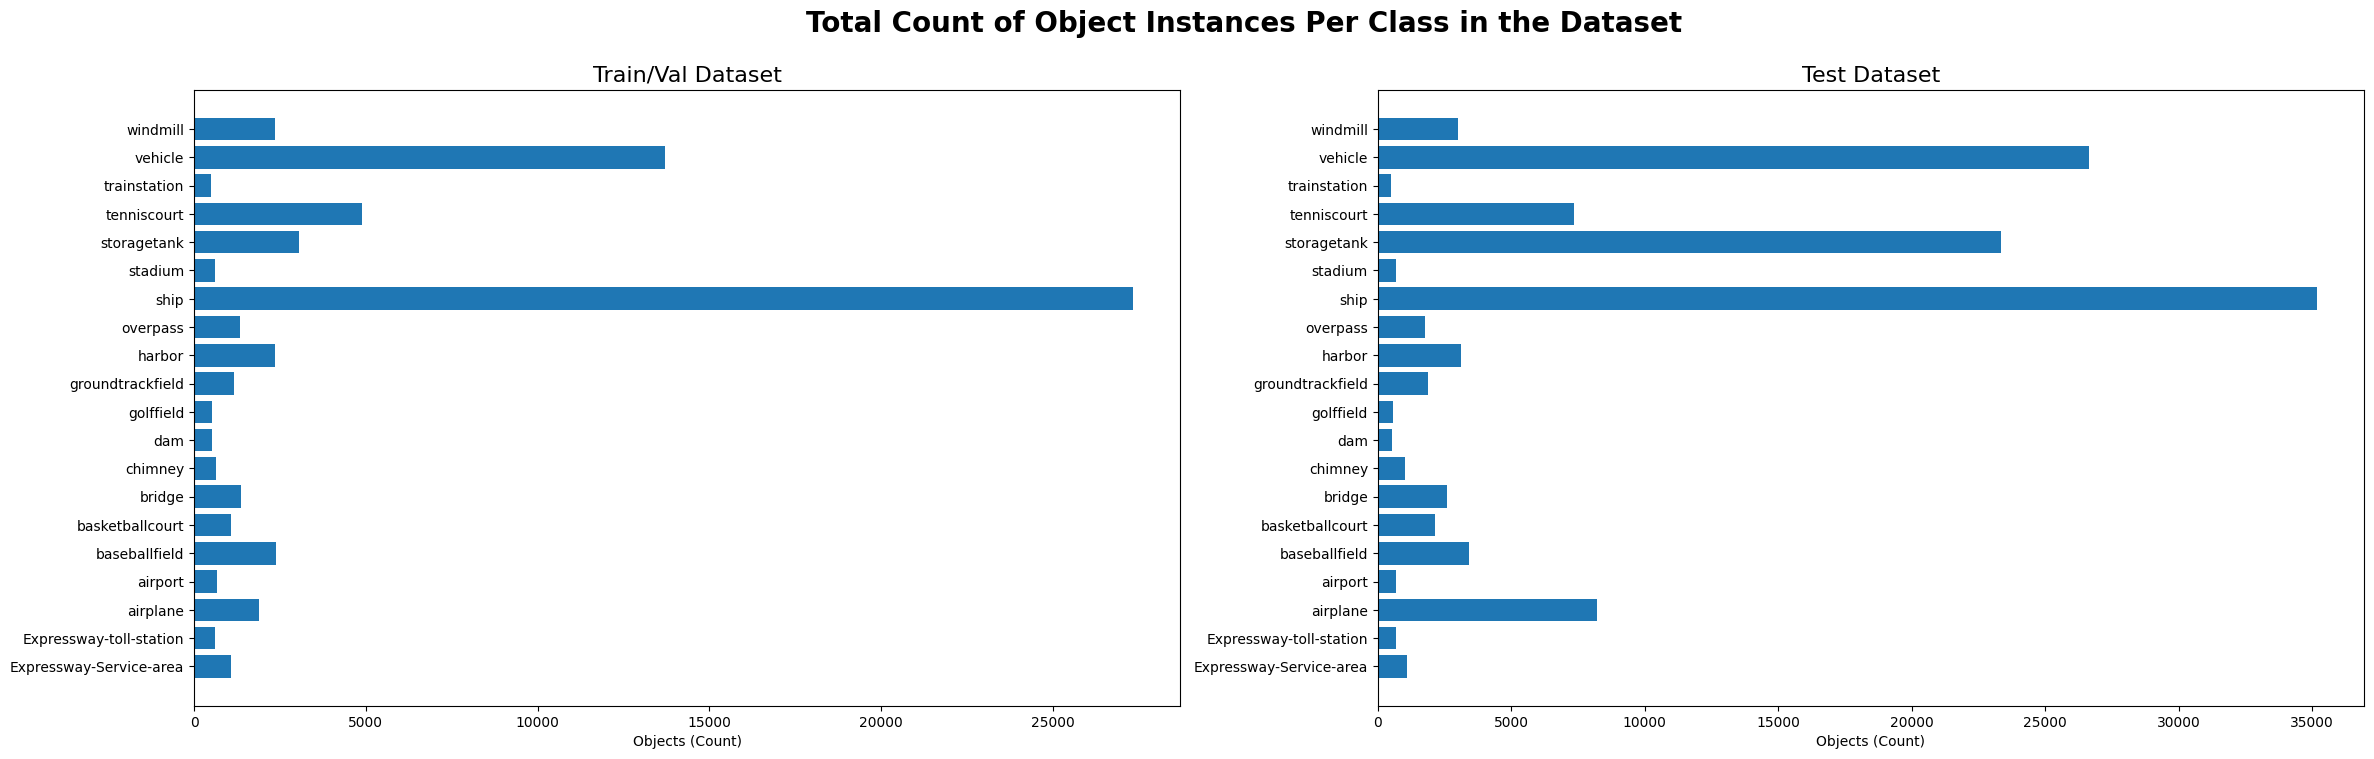

In [16]:
plt.figure(figsize=(28, 8))
plt.subplot(1, 2, 1)
plt.barh(list(object_instance_list_train.keys()), list(object_instance_list_train.values()))
plt.xlabel('Objects (Count)')
plt.title('Train/Val Dataset', fontsize=16)
plt.subplot(1, 2, 2)
plt.barh(list(object_instance_list_test.keys()), list(object_instance_list_test.values()))
plt.xlabel('Objects (Count)')
plt.title('Test Dataset', fontsize=16)
plt.suptitle('Total Count of Object Instances Per Class in the Dataset', fontsize=20, fontweight='bold');

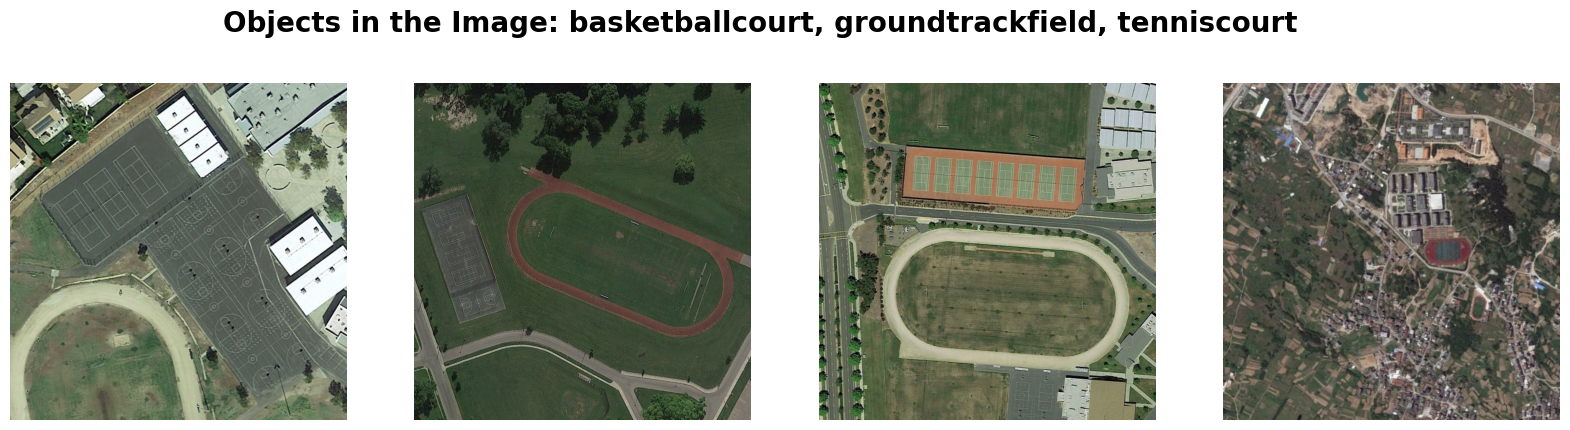

In [17]:
# Visualizing the classes - rerun the code for different classes.
viz_class = random.sample(meta_df.objects.tolist(), 1)[0]
viz_list = meta_df[meta_df['objects'] == viz_class].filename.tolist()
plt.figure(figsize=(20, 5))
rand = random.sample(viz_list, 4)
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(plt.imread(rand[i]))
    plt.suptitle(f'Objects in the Image: {viz_class}', fontsize=20, fontweight='bold')
    plt.axis(False)

## Convert annotation to YOLO format

In [18]:
# Creating a function for extracting data
def extract_data_from_xml(xml_file: str):
    """
    A function to extract data like filename, size, classes and bboxes from xml file.
    
    Parameters: xml_file: str, A string containing the path to the file.
    
    Returns: data_dict: dict, A dict containing all the extracted data.
    """
    root = ElementTree.parse(xml_file).getroot()
    
    # Creating dict and list to store data
    data_dict = {}
    data_dict['bboxes'] = []
    
    # Reading the xml file
    for element in root:
        # Getting the filename
        if element.tag == 'filename':
            data_dict['filename'] = element.text
        
        # Getting the image size
        elif element.tag == 'size':
            image_size = []
            for size_element in element:
                image_size.append(int(size_element.text))
            data_dict['image_size'] = image_size
        
        # Getting the bounding box
        elif element.tag == 'object':
            bbox = {}
            for obj_element in element:
                # Object or Class name
                if obj_element.tag == 'name':
                    bbox['class'] = obj_element.text
                # Object bounding box 
                elif obj_element.tag == 'bndbox':
                    for bbox_element in obj_element:
                        bbox[bbox_element.tag] = int(bbox_element.text)
            data_dict['bboxes'].append(bbox)
    return data_dict

In [19]:
example = extract_data_from_xml(annot_file_list[1])
example

{'bboxes': [{'class': 'Expressway-toll-station',
   'xmin': 231,
   'ymin': 221,
   'xmax': 303,
   'ymax': 304},
  {'class': 'vehicle', 'xmin': 49, 'ymin': 231, 'xmax': 67, 'ymax': 242},
  {'class': 'vehicle', 'xmin': 54, 'ymin': 252, 'xmax': 72, 'ymax': 262},
  {'class': 'vehicle', 'xmin': 297, 'ymin': 227, 'xmax': 316, 'ymax': 239}],
 'filename': '00002.jpg',
 'image_size': [800, 800, 3]}

In [20]:
# Creating a function to create a YOLO format annotation
def convert_dict_to_yolo(data_dict: dict):
    """
    A function to convert the extracted data dict into a text file as per the YOLO format.
    The final text file is saved in the directory "dior_data/yolo_annotations/data_dict['filename'].txt".
    
    Parameters: data_dict: dict, A dict containing the data.
    """
    data = []
    
    # Reading the bounding box data
    for bbox in data_dict['bboxes']:
        try:
            class_id = class_dict[bbox['class']]
        except KeyError:
            print(f'Invalid Class. Object class: "{bbox["class"]}" not present in the class list.')
            
        # Transforming the bbox in Yolo format [X, Y, W, H]
        img_w, img_h, _ = data_dict['image_size'] # Normalizing the bbox using image size
        
        x_center = ((bbox['xmin'] + bbox['xmax']) / 2) / img_w
        y_center = ((bbox['ymin'] + bbox['ymax']) / 2) / img_h
        width = (bbox['xmax'] - bbox['xmin']) / img_w 
        height = (bbox['ymax'] - bbox['ymin']) / img_h
        
        # Writing the new data to the data list in Yolo format
        data.append(f'{class_id} {x_center:.3f} {y_center:.3f} {width:.3f} {height:.3f}')
        
    # File name for saving the text file(same as xml and jpg file name)
    yolo_annot_dir = os.path.join('dior_data', 'yolo_annotations')
    if not os.path.exists(yolo_annot_dir):
        os.makedirs(yolo_annot_dir)
    save_file_name = os.path.join(yolo_annot_dir, data_dict['filename'].replace('jpg', 'txt'))
    
    # Saving the yolo annotation in a text file
    f = open(save_file_name, 'w+')
    f.write('\n'.join(data))
    f.close()

In [31]:
# Converting all the xml files into Yolo format text files
print('[INFO] Annotation extraction and creation into Yolo has started.')
for annot_file in tqdm(annot_file_list):
    data_dict = extract_data_from_xml(annot_file)
    convert_dict_to_yolo(data_dict)
print('[INFO] All the annotation are converted into Yolo format.')

[INFO] Annotation extraction and creation into Yolo has started.


100%|██████████| 23463/23463 [00:04<00:00, 4786.01it/s]

[INFO] All the annotation are converted into Yolo format.


In [22]:
yolo_annot_path = 'dior_data/yolo_annotations'
yolo_annot_file_list = sorted([os.path.join(yolo_annot_path, i) for i in os.listdir(yolo_annot_path) if '.txt' in i])
yolo_annot_file_list[:5], yolo_annot_file_list[-5:], len(yolo_annot_file_list)

(['dior_data/yolo_annotations/00001.txt',
  'dior_data/yolo_annotations/00002.txt',
  'dior_data/yolo_annotations/00003.txt',
  'dior_data/yolo_annotations/00004.txt',
  'dior_data/yolo_annotations/00005.txt'],
 ['dior_data/yolo_annotations/23459.txt',
  'dior_data/yolo_annotations/23460.txt',
  'dior_data/yolo_annotations/23461.txt',
  'dior_data/yolo_annotations/23462.txt',
  'dior_data/yolo_annotations/23463.txt'],
 23463)

In [23]:
class_dict_idx = dict(zip(class_dict.values(), class_dict.keys()))
class_dict_idx

{0: 'Expressway-Service-area',
 1: 'Expressway-toll-station',
 2: 'airplane',
 3: 'airport',
 4: 'baseballfield',
 5: 'basketballcourt',
 6: 'bridge',
 7: 'chimney',
 8: 'dam',
 9: 'golffield',
 10: 'groundtrackfield',
 11: 'harbor',
 12: 'overpass',
 13: 'ship',
 14: 'stadium',
 15: 'storagetank',
 16: 'tenniscourt',
 17: 'trainstation',
 18: 'vehicle',
 19: 'windmill'}

In [24]:
def plot_bboxes(img_file: str, annot_file: str, class_dict: dict):
    """
    A function to plot the bounding boxes amd their object classes onto the image.
    
    Parameters:
        img_file: str, A string containing the path to the image file.
        annot_file: str, A string containing the path to the annotation file in yolo format.
        class_dict: dict, A dict containing the classes in the similar sequence as per the annot_file.
    """
    # Reading the image and annot file
    image = cv2.imread(img_file)
    img_h, img_w, _ = image.shape
    
    with open(annot_file, 'r') as f:
        data = f.read().split('\n')
        data = [i.split(' ') for i in data]
        data = [[float(j) for j in i] for i in data]
    
    # Calculating the bbox in Pascal VOC format
    for bbox in data:
        class_idx, x_center, y_center, width, height = bbox
        xmin = int((x_center - width / 2) * img_w)
        ymin = int((y_center - height / 2) * img_h)
        xmax = int((x_center + width / 2) * img_w)
        ymax = int((y_center + height / 2) * img_h)
        
        # Correcting bbox if out of image size
        if xmin < 0:
            xmin = 0
        if ymin < 0:
            ymin = 0
        if xmax > img_w - 1:
            xmax = img_w - 1
        if ymax > img_h - 1:
            ymax = img_h - 1
        
        # Creating the box and label for the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 255, 0), 2)
        cv2.putText(image, class_dict[class_idx], (xmin, 0 if ymin-10 < 0 else ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
    
    # Displaying the image
    plt.imshow(image)
    plt.axis(False)

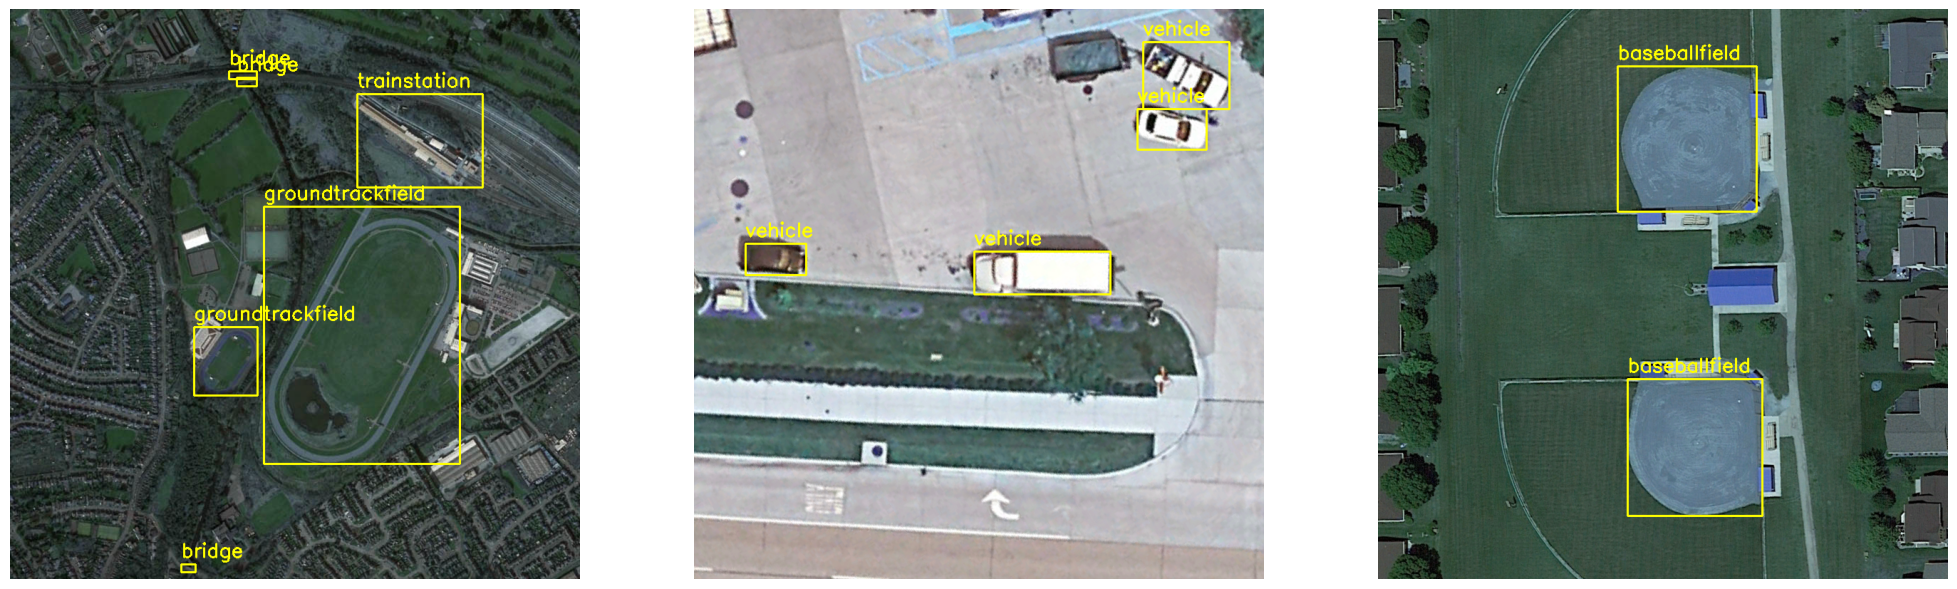

In [25]:
plt.figure(figsize=(25, 8))
rand_int = random.sample(range(len(yolo_annot_file_list)), 3)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_bboxes(image_data_file_list[rand_int[i]], yolo_annot_file_list[rand_int[i]], class_dict_idx)

## Preprocess Images

### Split Dataset folder in train/test/val

In [32]:
# Creating images and labels directory into the data directory
root_dir = 'dataset'
image_dir = 'dataset/images'
label_dir = 'dataset/labels'
img_train_dir = 'dataset/images/train'
label_train_dir = 'dataset/labels/train'
img_test_dir = 'dataset/images/test'
label_test_dir = 'dataset/labels/test'


In [33]:
# Moving the training labels
if not os.path.exists(label_train_dir):
    os.makedirs(label_train_dir)

for filepath in tqdm(trainval_file_list):
    file_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    if os.path.isfile(file_path):
        shutil.copy(file_path, label_train_dir)

100%|██████████| 11725/11725 [00:01<00:00, 11586.34it/s]


In [35]:
# Moving the validation labels[20% of test dataset]
if not os.path.exists(label_test_dir):
    os.makedirs(label_test_dir)

for filepath in tqdm(test_file_list):
    file_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    if os.path.isfile(file_path):
        shutil.move(file_path, label_test_dir)

100%|██████████| 11738/11738 [00:00<00:00, 25186.09it/s]


### Resize

In [ ]:

# Function to resize images
def resize_images(input_folder, output_folder, new_size=(416, 416)):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Assuming images are either jpg or png
            # Open the image
            with Image.open(os.path.join(input_folder, filename)) as img:
                # Resize the image
                resized_img = img.resize(new_size)
                # Save the resized image to the output folder
                resized_img.save(os.path.join(output_folder, filename))

# Define input and output folders
input_folder_train = "dataset/images/train"
output_folder_train = "dataset/images/train"

input_folder_test = "dataset/images/test"
output_folder_test = "dataset/images/test"


# Call the function to resize images
resize_images(input_folder_train, output_folder_train)
resize_images(input_folder_test, output_folder_test)

print("Images resized successfully!")


Images resized successfully!


### Extract images only from one classes

#### Train

In [38]:
import os
import shutil

# Define the paths to your dataset folders
dataset_folder = "dataset"
images_folder = os.path.join(dataset_folder, "images/train")
labels_folder = os.path.join(dataset_folder, "labels/train")

# Define the class IDs you want to isolate
target_class_ids = [18,19]

# Create a new folder to store the isolated images and labels
output_images_folder = "one_class_dataset/images/train"
output_labels_folder = "one_class_dataset/labels/train"
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)
count = 0
# Iterate through each label file in the labels folder
for label_file in os.listdir(labels_folder):
    label_path = os.path.join(labels_folder, label_file)
    
    # Open the label file and read its contents
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Filter lines based on the class IDs
    filtered_lines = [line.strip().split(' ') for line in lines if int(line.strip().split(' ')[0]) in target_class_ids]
    
    # If there are any lines for the target class IDs, copy the corresponding image and label file
    if filtered_lines:
        count += 1
        image_file = label_file.replace('.txt', '.jpg')  # Assuming image file extensions are jpg
        image_path = os.path.join(images_folder, image_file)
        
        # Copy the image file to the output folder
        shutil.copy(image_path, output_images_folder)
        
        # Write the modified label lines to a new label file in the output folder
        output_label_path = os.path.join(output_labels_folder, label_file)
        with open(output_label_path, 'w') as f:
            for line in filtered_lines:
                if line[0] == '18':
                    line[0] = '0'
                elif line[0] == '19':
                    line[0] = '1'
                f.write(' '.join(line) + '\n')
print(f"Total number of images with target classes: {count}")

Total number of images with target classes: 1132


#### Test

In [39]:
import os
import shutil

# Define the paths to your dataset folders
dataset_folder = "dataset"
images_folder = os.path.join(dataset_folder, "images/test")
labels_folder = os.path.join(dataset_folder, "labels/test")

# Define the class IDs you want to isolate
target_class_ids = [0,1]

# Create a new folder to store the isolated images and labels
output_images_folder = "one_class_dataset/images/test"
output_labels_folder = "one_class_dataset/labels/test"
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)
count = 0
# Iterate through each label file in the labels folder
for label_file in os.listdir(labels_folder):
    label_path = os.path.join(labels_folder, label_file)
    
    # Open the label file and read its contents
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Filter lines based on the class IDs
    filtered_lines = [line.strip().split(' ') for line in lines if int(line.strip().split(' ')[0]) in target_class_ids]
    
    # If there are any lines for the target class IDs, copy the corresponding image and label file
    if filtered_lines:
        count += 1
        image_file = label_file.replace('.txt', '.jpg')  # Assuming image file extensions are jpg
        image_path = os.path.join(images_folder, image_file)
        
        # Copy the image file to the output folder
        shutil.copy(image_path, output_images_folder)
        
        # Write the modified label lines to a new label file in the output folder
        output_label_path = os.path.join(output_labels_folder, label_file)
        with open(output_label_path, 'w') as f:
            for line in filtered_lines:
                f.write(' '.join(line) + '\n')
                
print(f"Total number of images with target classes: {count}")

Total number of images with target classes: 1156


## Implement YOLO architecture

In [40]:
class TinyYOLOv1(nn.Module):
    def __init__(self, B=2, num_classes=2):
        super(TinyYOLOv1, self).__init__()
        S = 7  # grid size
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.square_activation1 = SquareActivation()
        self.batch_norm1 = nn.BatchNorm2d(8)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.square_activation2 = SquareActivation()
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4096, 2048)
        self.square_activation_ft = SquareActivation()
        self.fc2 = nn.Linear(2048, S * S * (B * 5 + num_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.square_activation1(x)
        x = self.batch_norm1(x)
        x = self.avgpool1(x)
        
        x = self.conv2(x)
        x = self.square_activation2(x)
        x = self.batch_norm2(x)
        x = self.avgpool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.square_activation_ft(x)
        x = self.fc2(x)
        return x

# Assuming the SquareActivation is defined somewhere else
class SquareActivation(nn.Module):
    def forward(self, x):
        return x * x

model = TinyYOLOv1()
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
TinyYOLOv1                               [1, 588]                  --
├─Conv2d: 1-1                            [1, 8, 128, 128]          224
├─SquareActivation: 1-2                  [1, 8, 128, 128]          --
├─BatchNorm2d: 1-3                       [1, 8, 128, 128]          16
├─AvgPool2d: 1-4                         [1, 8, 64, 64]            --
├─Conv2d: 1-5                            [1, 16, 32, 32]           1,168
├─SquareActivation: 1-6                  [1, 16, 32, 32]           --
├─BatchNorm2d: 1-7                       [1, 16, 32, 32]           32
├─AvgPool2d: 1-8                         [1, 16, 16, 16]           --
├─Flatten: 1-9                           [1, 4096]                 --
├─Linear: 1-10                           [1, 2048]                 8,390,656
├─SquareActivation: 1-11                 [1, 2048]                 --
├─Linear: 1-12                           [1, 588]                  1,204,8

In [ ]:
import torch
import torch.nn as nn

# Assuming the SquareActivation is defined somewhere else
class SquareActivation(nn.Module):
    def forward(self, x):
        return x * x

class TinyYOLO(nn.Module):
    def __init__(self, num_classes=80):
        super(TinyYOLO, self).__init__()

        self.conv1 = self._conv_layer(3, 16, 3, 1, 1)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = self._conv_layer(16, 32, 3, 1, 1)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.conv3 = self._conv_layer(32, 64, 3, 1, 1)
        self.pool3 = nn.AvgPool2d(2, 2)
        self.conv4 = self._conv_layer(64, 128, 3, 1, 1)
        self.pool4 = nn.AvgPool2d(2, 2)
        self.conv5 = self._conv_layer(128, 256, 3, 1, 1)
        self.pool5 = nn.AvgPool2d(2, 2)
        self.conv6 = self._conv_layer(256, 512, 3, 1, 1)
        self.pool6 = nn.AvgPool2d(2, 1)
        self.conv7 = self._conv_layer(512, 1024, 3, 1, 1)
        
        self.conv8 = self._conv_layer(1024, 512, 3, 1, 1)
        self.conv9 = self._conv_layer(512, 425, 1, 1, 1, batch_norm=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.conv6(x)
        x = self.pool6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)

        return x

    def _conv_layer(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm=True):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(SquareActivation())
        return nn.Sequential(*layers)

# Create an instance of the TinyYOLO model
model = TinyYOLO()

# Test the model with a random input
input_tensor = torch.randn(1, 3, 416, 416)  # batch_size, channels, height, width
output_tensor = model(input_tensor)
print("Output tensor shape:", output_tensor.shape)


## Utility Function

### Intersection over Union

In [5]:
def intersection_over_union(boxes_preds, boxes_labels):
    """
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)    
    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    #boxes_labels shape is (n, 4)
    
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    #print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")
    
    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    #print(f"intersection: {intersection}")

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    #print(f"box1_area: {box1_area}, box2_area: {box2_area}")
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

### Non Max Suppression

**Input**: A list of Proposal boxes B, corresponding confidence scores S and overlap threshold N.

**Output**: A list of filtered proposals D.

Algorithm:

1.  Select the proposal with highest confidence score, remove it from B and add it to the final proposal list D. (Initially D is empty).
2.  Now compare this proposal with all the proposals — calculate the IOU (Intersection over Union) of this proposal with every other proposal. If the IOU is greater than the threshold N, remove that proposal from B.
3.  Again take the proposal with the highest confidence from the remaining proposals in B and remove it from B and add it to D.
4.  Once again calculate the IOU of this proposal with all the proposals in B and eliminate the boxes which have high IOU than threshold.
5.  This process is repeated until there are no more proposals left in B.


In [6]:
def non_max_suppression(bboxes, iou_threshold, threshold):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x_center, y_center, width, height]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)
    #print(f"bboxes_after_nms: {bboxes_after_nms}")

    return bboxes_after_nms

### Mean Average Precision

It describes a trade-off between precision and recall.

**Precision**, also referred to as the positive predictive value, describes how well a model predicts the positive class. 
$$Precision=\frac{TP}{TP+FP}$$
>   Of all bounding box **predictions**, what fraction was actually correct?

**Recall**, also called sensitivity tells you if your model made the right predictions when it should have. 
$$Recall=\frac{TP}{TP+FN}$$
>   Of all **target** bounding boxes, what fraction did we correctly detect?


In [41]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, num_classes=2
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x_center, y_center, width, height]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        #print(f"{c} class has {len(detections)} detections")

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        #print(f"{c} class has {len(ground_truths)} ground truths")

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        #print(f"{c} class has {len(amount_bboxes)} amount bboxes")

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        #print(f"{c} class has {total_true_bboxes} total true bboxes")
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            #print(f"{c} class has {num_gts} ground truths for detection {detection_idx}")
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    #These additional detections are considered false positives because they do not correspond to a new, unique object
                    #they're essentially "over-detecting" an object that has already been correctly identified.
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        #[1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

### Plot image

In [8]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        class_label = int(box[0])
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add class label text
        ax.text(upper_left_x * width, upper_left_y * height, str(class_label), color='r', fontsize=10, verticalalignment='bottom')

    plt.show()


### Get and convert boxes

In [42]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
            )

            # # Activate only for test
            # if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


In [43]:
def convert_cellboxes(predictions, S=7, C=2):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios.
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    # This results in a tensor with shape (batch_size, 7, 7, 1) where each element represents the index of a grid cell.
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)

    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    # Permute because is used here to swap these indices to match the (x, y) convention used in the best_boxes tensor.
    # [0,1,2]->[0,0,0]
    # [0,1,2]->[1,1,1]
    # [0,1,2]->[2,2,2]
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]

    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )
    #print(f"converted_preds: {converted_preds}")

    return converted_preds

In [11]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)
    #print(f"all_bboxes: {all_bboxes}")
    return all_bboxes

## Create Loader of Dataset

In [44]:


class DiorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=7, B=2, C=2, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

        # Determine the directory of the images and labels
        if self.train:
            self.img_dir = os.path.join(self.root_dir, 'images/train')
            self.label_dir = os.path.join(self.root_dir, 'labels/train')
        else:
            self.img_dir = os.path.join(self.root_dir, 'images/test')
            self.label_dir = os.path.join(self.root_dir, 'labels/test')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        boxes = []

        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        image = image.convert("RGB")

        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                boxes.append([class_label, x, y, width, height])

        boxes = torch.tensor(boxes)
        #print(f"boxes: {boxes}")
        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, self.C + 1:self.C + 5] = box_coordinates
                label_matrix[i, j, class_label] = 1
    
        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix

## YOLO Loss

From original paper: 
>   YOLO predicts multiple bounding boxes per grid cell. At training time we only want one bounding box predictor to be responsible for each object. We assign one predictor to be “responsible” for predicting an object based on which prediction has the highest current IOU with the ground truth. This leads to specialization between the bounding box predictors.
Each predictor gets better at predicting certain sizes, aspect ratios, or classes of object, improving overall recall. 

$$
\begin{gathered}
\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(x_i-\hat{x}_i\right)^2+\left(y_i-\hat{y}_i\right)^2\right] \\
+\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(\sqrt{w_i}-\sqrt{\hat{w}_i}\right)^2+\left(\sqrt{h_i}-\sqrt{\hat{h}_i}\right)^2\right] \\
+\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left(C_i-\hat{C}_i\right)^2 \\
+\lambda_{\text {noobj }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {noobj }}\left(C_i-\hat{C}_i\right)^2 \\
+\sum_{i=0}^{S^2} \mathbb{1}_i^{\text {obj }} \sum_{c \in \text { classes }}\left(p_i(c)-\hat{p}_i(c)\right)^2
\end{gathered}
$$

During training we optimize the following, multi-part where $ 1_{obj}^i $ denotes if object appears in cell **i** and $1_{obj}^{ij}$ denotes that the **j**  bounding box predictor in cell i is “responsible” for that prediction.

In every image many grid cells do not contain any object. This pushes the “confidence” scores of those cells towards zero, often overpowering the gradient from cells that do contain objects. This can lead to model instability, as the model may prioritize learning to predict empty cells rather than focusing on correctly detecting objects in cells containing them, causing training to diverge early on. To remedy this, we increase the loss from bounding box coordinate predictions and decrease the loss from confidence predictions for boxes that don’t contain objects. We use two parameters, $\lambda_{coord}$ and $\lambda_{noobj}$  to accomplish this.

Note that the loss function only penalizes classification error if an object is present in that grid cell (hence the conditional class probability discussed earlier). It also only penalizes bounding box coordinate error if that predictor is “responsible” for the ground truth box (i.e. has the highest
IOU of any predictor in that grid cell).

In [45]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=2):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]
            )
        )
        #print(f"box_predictions: {box_predictions.shape}")
        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## Training

In [14]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 10
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [15]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

In [16]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.ToTensor()])

### Combine all

In [46]:
files_dir = 'one_class_dataset'
model = TinyYOLO(num_classes=20).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
loss_fn = YoloLoss()


train_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform
)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)


/home/ec2-user/ObjDct_Master_Thesis/venv/lib64/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [47]:

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_fn(train_loader, model, optimizer, loss_fn)
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )
    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5
    )
    print(f"Train mAP: {mean_avg_prec}")
    scheduler.step(mean_avg_prec)



Epoch 1/10


100%|██████████| 71/71 [00:06<00:00, 11.82it/s, loss=316]


Mean loss was 514.3704829686125
Train mAP: 7.522381201852113e-05
Epoch 2/10


100%|██████████| 71/71 [00:06<00:00, 11.71it/s, loss=187]


Mean loss was 348.34430941729477
Train mAP: 0.0004304726026020944
Epoch 3/10


100%|██████████| 71/71 [00:05<00:00, 11.98it/s, loss=140]


Mean loss was 271.598535242215
Train mAP: 0.0007172073237597942
Epoch 4/10


100%|██████████| 71/71 [00:06<00:00, 11.41it/s, loss=109]    


Mean loss was 252.52885232844824
Train mAP: 0.0023668846115469933
Epoch 5/10


100%|██████████| 71/71 [00:06<00:00, 11.70it/s, loss=111]    


Mean loss was 224.266533220318
Train mAP: 0.0061011225916445255
Epoch 6/10


100%|██████████| 71/71 [00:05<00:00, 11.88it/s, loss=144] 


Mean loss was 168.44835727315552
Train mAP: 0.009437350556254387
Epoch 7/10


100%|██████████| 71/71 [00:06<00:00, 11.75it/s, loss=72.7]


Mean loss was 140.70390932324906
Train mAP: 0.012496571987867355
Epoch 8/10


100%|██████████| 71/71 [00:05<00:00, 12.00it/s, loss=308] 


Mean loss was 126.41247891708159
Train mAP: 0.02916637994349003
Epoch 9/10


100%|██████████| 71/71 [00:06<00:00, 11.82it/s, loss=90.5]


Mean loss was 106.62104958547673
Train mAP: 0.033925652503967285
Epoch 10/10


100%|██████████| 71/71 [00:05<00:00, 11.94it/s, loss=48]  


Mean loss was 103.78698993736589
Train mAP: 0.04600819945335388


In [48]:
torch.save(model.state_dict(), "model.pth")

## Testing

### Load test set

In [49]:
files_dir='one_class_dataset'
    
test_dataset = DiorDataset( 
    root_dir=files_dir,
    transform=transform,
    train=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

### Load model and make inference

In [21]:

checkpoint = torch.load("model.pth")
# Load the state dictionary from the .pth file

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Ensure the model is in evaluation mode
model.eval()


TinyYOLOv1(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (square_activation1): SquareActivation()
  (batch_norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (square_activation2): SquareActivation()
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (square_activation_ft): SquareActivation()
  (fc2): Linear(in_features=2048, out_features=539, bias=True)
)

In [22]:
model.eval()

with torch.no_grad():
    pred_boxes, target_boxes = get_bboxes(
        test_loader, model, iou_threshold=0.5, threshold=0.4
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5
    )
    print(f"Test mAP: {mean_avg_prec}")

Test mAP: 0.004085736349225044


In [50]:
sample = torch.rand(1, 3, 256, 256)
model.eval()
output = model(sample)
print(output.shape)

torch.Size([1, 588])


In [51]:

# Set the path to save the ONNX model
onnx_model_path = "model.onnx"

# Export the model to ONNX format
torch.onnx.export(model, sample, onnx_model_path)


# PYHELAYERS

## Select a subset of plain samples from test set

In [52]:
test_img_list=[]
test_label_list=[]
for image,label in test_dataset:
    test_img_list.append(image)
    test_label_list.append(label)
    if len(test_img_list)==1:
        break

test_img_array = np.array(test_img_list)
test_label_array = np.array(test_label_list)
# test_img_array = test_img_array[:11728]
# test_label_array = test_label_array[:11728]
# test_img_array = test_img_array.reshape(733,16,3,64,64)
# test_label_array = test_label_array.reshape(733,16,7,7,30)
print(test_img_array.shape)
print(test_label_array.shape)

(1, 3, 256, 256)
(1, 7, 7, 12)


## Initialize he scheme

In [53]:
import pyhelayers
import utils

utils.verify_memory()

print('Misc. initalizations')

Misc. initalizations


In [54]:
context = pyhelayers.DefaultContext()
print('HE context ready')

HE context ready


In [55]:

nnp = pyhelayers.NeuralNetPlain()

In [56]:
hyper_params = pyhelayers.PlainModelHyperParams()
nnp.init_from_files(hyper_params, ["model.onnx"])


In [57]:
he_run_req = pyhelayers.HeRunRequirements()
he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
he_run_req.optimize_for_batch_size(1)

profile = pyhelayers.HeModel.compile(nnp, he_run_req)
batch_size = profile.get_optimal_batch_size()
print('Profile ready. Batch size=',batch_size)

Profile ready. Batch size= 1


In [29]:
profile.get_he_config_requirement()

He configuration requirement:
Security level: 128
Integer part precision: 10
Fractional part precision: 50
Number of slots: 16384
Multiplication depth: 11
Bootstrappable: False
Automatic bootstrapping: False
Rotation keys policy: custom, 20 keys required:
[-4096, -2048, -1024, -512, -256, -128, -64, -32, -16, 16, 32, 64, 128, 256, 512, 1024, 2048, 3072, 4096, 8192]

In [58]:
context = pyhelayers.HeModel.create_context(profile)
print('HE context initalized')

HE context initalized


In [31]:
context.get_scheme_name()

'CKKS'

In [32]:
context.get_default_scale()

1125899903956542.8

In [33]:
context.get_library_name()

'SEAL'

In [34]:
context.has_secret_key()

True

In [36]:
context.save_secret_key_to_file('secret_key.txt')

In [59]:
nn = pyhelayers.NeuralNet(context)
nn.encode_encrypt(nnp, profile)
print('Encrypted network ready')

Encrypted network ready


In [60]:
plain_samples, labels = utils.extract_batch(test_img_array, test_label_array, batch_size, 0)

print('Batch of size',batch_size,'loaded')

Batch of size 1 loaded


In [40]:
print(plain_samples.shape)
print(plain_samples.dtype)

(16, 3, 64, 64)
float32


In [61]:
iop = nn.create_io_processor()
samples = pyhelayers.EncryptedData(context)
iop.encode_encrypt_inputs_for_predict(samples, [plain_samples])
print('Test data encrypted')

Test data encrypted


## Make prediction on encrypted data

In [62]:
utils.start_timer()

predictions = pyhelayers.EncryptedData(context)
nn.predict(predictions, samples)

duration=utils.end_timer('predict')
utils.report_duration('predict per sample',duration/batch_size)

Duration of predict: 66.590 (s)
Duration of predict per sample: 66.590 (s)


In [43]:
plain_predictions_aHE = iop.decrypt_decode_output(predictions)
print(f"plain prediction shape after HE: {plain_predictions_aHE.shape}")

plain prediction shape after HE: (16, 1470)


In [44]:
type(plain_predictions_aHE)

numpy.ndarray

In [ ]:
## In case I have test samples > batch size
plain_predictions_aHE = plain_predictions_aHE.reshape(,1470)

## Evaluate prediction with HE

In [47]:
plain_predictions_bHE=[]
for sample in test_img_array:
    tensor_sample = torch.tensor(sample).unsqueeze(0)
    output = model(tensor_sample)
    output = output.detach().numpy()
    plain_predictions_bHE.append(output)
plain_predictions_bHE = np.array(plain_predictions_bHE)
plain_predictions_bHE = plain_predictions_bHE.reshape(16, 1470)
print(f"plain prediction shape before HE: {plain_predictions_bHE.shape}")


plain prediction shape before HE: (16, 1470)


In [53]:

# Compute the absolute differences between plain prediction before and after HE
differences = np.abs(plain_predictions_bHE - plain_predictions_aHE)

# Compute relevant statistics
mean_difference = np.mean(differences)
max_difference = np.max(differences)
min_difference = np.min(differences)
std_difference = np.std(differences)

print(f"Mean difference: {mean_difference}")
print(f"Max difference: {max_difference}")
print(f"Min difference: {min_difference}")
print(f"Std difference: {std_difference}")


Mean difference: 8.096096892812246e-08
Max difference: 1.0847093330212942e-06
Min difference: 4.0473735474222394e-12
Std difference: 7.963937368555468e-08


### Convert prediction in bounding boxes

In [49]:
def get_bboxes_from_prediction(
    predictions,
    test_image_array,
    iou_threshold,
    threshold,
):
    all_pred_boxes = []

    
    train_idx = 0

    bboxes = cellboxes_to_boxes(predictions)

    for idx in range(len(test_image_array)):
        image = test_image_array[idx]

        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
        )

        # Activate only for test
        if  idx == 0:
            plot_image(image.permute(1,2,0).to("cpu"), nms_boxes)

        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

        

        train_idx += 1

    return all_pred_boxes


Prediction before HE


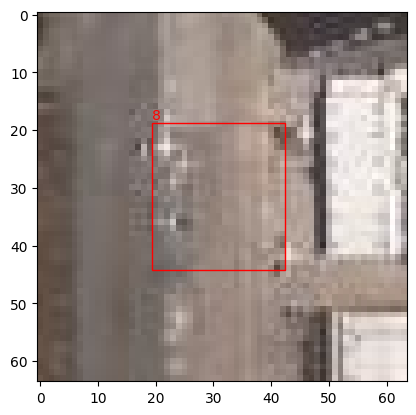

Prediction after HE


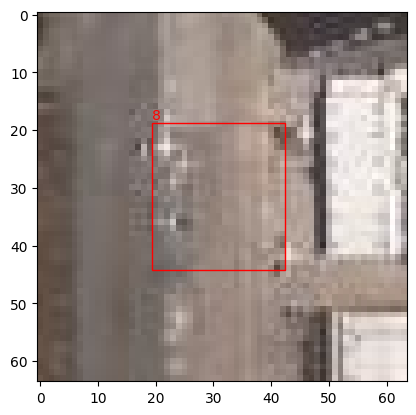

In [52]:
tensor_predaHE = torch.tensor(plain_predictions_aHE)
tensor_predbHE = torch.tensor(plain_predictions_bHE)
tensor_imgs = torch.tensor(test_img_array)

print("Prediction before HE")
bboxes_aHE = get_bboxes_from_prediction(tensor_predbHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)

print("Prediction after HE")
bboxes_bHE = get_bboxes_from_prediction(tensor_predaHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)